# ResNet50 Training for Translation + Rotation (Pose Estimation)


This notebook allows you to:
1. **Import and Setup**
2. **Load LineMOD dataset**
3. **Initialize PoseEstimator** (ResNet-50 backbone)
4. **Training**
5. **Evaluation on test set**

## 1. Import and Setup

In [1]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent)) 
from config import Config
from models.pose_estimator_endtoend import PoseEstimator
from utils.losses import PoseLoss
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import plot_training_validation_loss_from_csv, show_pose_samples_with_add, plot_add_per_class
from utils.training import train_pose_full
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_full_pose
from utils.file_io import load_all_models, load_models_info
from utils.validation import run_deep_pose_pipeline

## 2. Load LineMOD dataset

In [ ]:
DATASET_DIR = Path(Config.LINEMOD_ROOT)
if not DATASET_DIR.exists():
    print("Dataset not found, start downloading...")
    from utils.download_dataset import download_linemod_dataset
    download_linemod_dataset()
else:
    print("Dataset LineMOD present.")

In [2]:
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


## 3. Initialize PoseEstimator Model

In [3]:
# Initialize the end-to-end model for rotation + translation (ResNet-50)
model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=True
).to(Config.DEVICE)

# Show minimal info about the model
params_info = model.get_num_parameters()
print(f"PoseEstimator model loaded on: {Config.DEVICE}")
print(f"Total parameters: {params_info['total']:,}")
print(f"Trainable parameters: {params_info['trainable']:,}")

/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=True)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
PoseEstimator model loaded on: mps
Total parameters: 26,137,671
Trainable parameters: 2,629,639


## 4. Name and path to train/load a model

In [12]:
# Useful parameters even when not training
NAME = "pose_rgb_endtoend"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training

In [5]:
# End-to-end training rotation + translation (PoseLoss)
EPOCHS = Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Save args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
print(f"LAMBDA_TRANS: {Config.LAMBDA_TRANS}, LAMBDA_ROT: {Config.LAMBDA_ROT}")

# Make sure the directory exists before saving the file
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)


# Load weights if already present and continue training
import os
if os.path.exists(str(best_path)):
    print(f"✅ Weights found: {best_path}. Loading and continuing training...")
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.train()
else:
    print("🔄 No previous model found, starting training from scratch...")


history, best_loss, best_epoch = train_pose_full(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)
print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completed!")

LAMBDA_TRANS: 10.0, LAMBDA_ROT: 5.0
✅ Weights found: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt. Loading and continuing training...


Epoch 1/30: 100%|██████████| 30/30 [00:17<00:00,  1.74it/s, loss=1571.3143, trans=156.1565, rot=1.95, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 1: loss=1598.2583, val_loss=1172.1730
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 2/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1535.5210, trans=152.7685, rot=1.57, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 2: loss=1579.5567, val_loss=1290.6213


Epoch 3/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1398.4747, trans=139.0318, rot=1.63, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 3: loss=1513.6524, val_loss=1189.8575


Epoch 4/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1390.6694, trans=138.2926, rot=1.55, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 4: loss=1452.6765, val_loss=1181.7010


Epoch 5/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1518.8369, trans=151.0137, rot=1.74, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 5: loss=1442.6814, val_loss=1142.1854
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 6/30: 100%|██████████| 30/30 [00:17<00:00,  1.69it/s, loss=1471.5439, trans=146.2972, rot=1.71, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 6: loss=1412.3001, val_loss=1164.2899


Epoch 7/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1368.5482, trans=136.0325, rot=1.64, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 7: loss=1309.4245, val_loss=1234.2551


Epoch 8/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1410.8612, trans=140.2823, rot=1.61, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 8: loss=1330.8606, val_loss=1120.6704
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 9/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1353.0765, trans=134.5253, rot=1.56, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 9: loss=1259.0000, val_loss=1152.2465


Epoch 10/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1242.7068, trans=123.3310, rot=1.88, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 10: loss=1222.1694, val_loss=1058.1480
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 11/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1272.2610, trans=126.3445, rot=1.76, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 11: loss=1185.5118, val_loss=1068.8915


Epoch 12/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1132.3937, trans=112.4514, rot=1.58, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 12: loss=1147.3283, val_loss=1124.1151


Epoch 13/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1045.8215, trans=103.7837, rot=1.60, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 13: loss=1093.2770, val_loss=1166.4342


Epoch 14/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1233.4276, trans=122.5084, rot=1.67, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 14: loss=1089.9748, val_loss=1054.9525
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 15/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1065.8916, trans=105.7941, rot=1.59, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 15: loss=1051.0212, val_loss=1134.6729


Epoch 16/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=1010.7527, trans=100.1460, rot=1.86, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 16: loss=1037.6711, val_loss=1091.2440


Epoch 17/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=948.6245, trans=93.9677, rot=1.79, lr_bb=1.00e-04, lr_hd=1.00e-04]  


Epoch 17: loss=988.1663, val_loss=1090.1994


Epoch 18/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=993.9166, trans=98.4989, rot=1.79, lr_bb=1.00e-04, lr_hd=1.00e-04]  


Epoch 18: loss=969.9953, val_loss=1112.7344


Epoch 19/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=823.2013, trans=81.4741, rot=1.69, lr_bb=1.00e-04, lr_hd=1.00e-04]  


Epoch 19: loss=937.1157, val_loss=1078.0767


Epoch 20/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=971.8329, trans=96.4437, rot=1.48, lr_bb=1.00e-04, lr_hd=1.00e-04] 


Epoch 20: loss=916.8205, val_loss=1113.1988


Epoch 21/30: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s, loss=840.6088, trans=83.1689, rot=1.78, lr_bb=1.00e-04, lr_hd=1.00e-04]  


Epoch 21: loss=919.1551, val_loss=1071.0459


Epoch 22/30: 100%|██████████| 30/30 [00:17<00:00,  1.69it/s, loss=1009.4290, trans=100.0975, rot=1.69, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 22: loss=907.6088, val_loss=1061.2550


Epoch 23/30: 100%|██████████| 30/30 [00:17<00:00,  1.69it/s, loss=754.6740, trans=74.6640, rot=1.61, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 23: loss=854.5806, val_loss=1068.5575


Epoch 24/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=819.7578, trans=81.2016, rot=1.55, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 24: loss=853.5522, val_loss=1034.8578
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 25/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=1023.7373, trans=101.4293, rot=1.89, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 25: loss=839.3821, val_loss=1081.3773


Epoch 26/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=820.4741, trans=81.1730, rot=1.75, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 26: loss=814.3387, val_loss=1062.1665


Epoch 27/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=900.8936, trans=89.2959, rot=1.59, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 27: loss=802.3056, val_loss=1095.8296


Epoch 28/30: 100%|██████████| 30/30 [00:17<00:00,  1.71it/s, loss=839.6097, trans=83.0230, rot=1.88, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 28: loss=789.4099, val_loss=1098.2935


Epoch 29/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=839.6453, trans=83.2801, rot=1.37, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 29: loss=787.1449, val_loss=1023.6461
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend3/weights/best.pt


Epoch 30/30: 100%|██████████| 30/30 [00:17<00:00,  1.72it/s, loss=749.3175, trans=74.1412, rot=1.58, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 30: loss=776.0383, val_loss=1108.0450

Best loss: 1023.6461 @ epoch 29
✅ Training completed!


### 5.1 Loss visualization

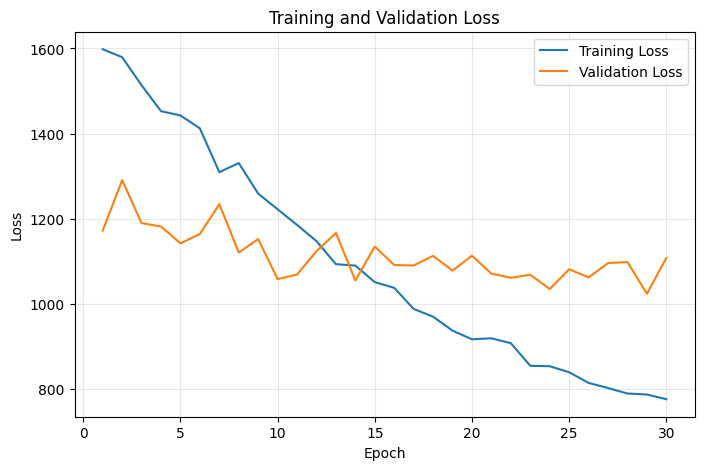

In [6]:
# Plot the training loss curve from CSV
training_csv_path = checkpoint_dir / 'training_result.csv'
plot_training_validation_loss_from_csv(training_csv_path)

## 6. Test and Evaluation on Test Set Samples

### 6.1 Show prediction on image batch

✅ Model pose_rgb_endtoend3 loaded and in eval mode!
Random batch: extracting random batch from test dataset
Random batch start index: 3423
Number of samples extracted: 64
Batch keys: ['rgb_crop', 'rgb', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'rgb_path', 'info_path']

Converting quaternions to rotation matrices
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points

Computing ADD full pose metric
Test completed on 64 samples

📊 Mean ADD on batch:
   Mean ADD: 73.4695 ± 18.7309


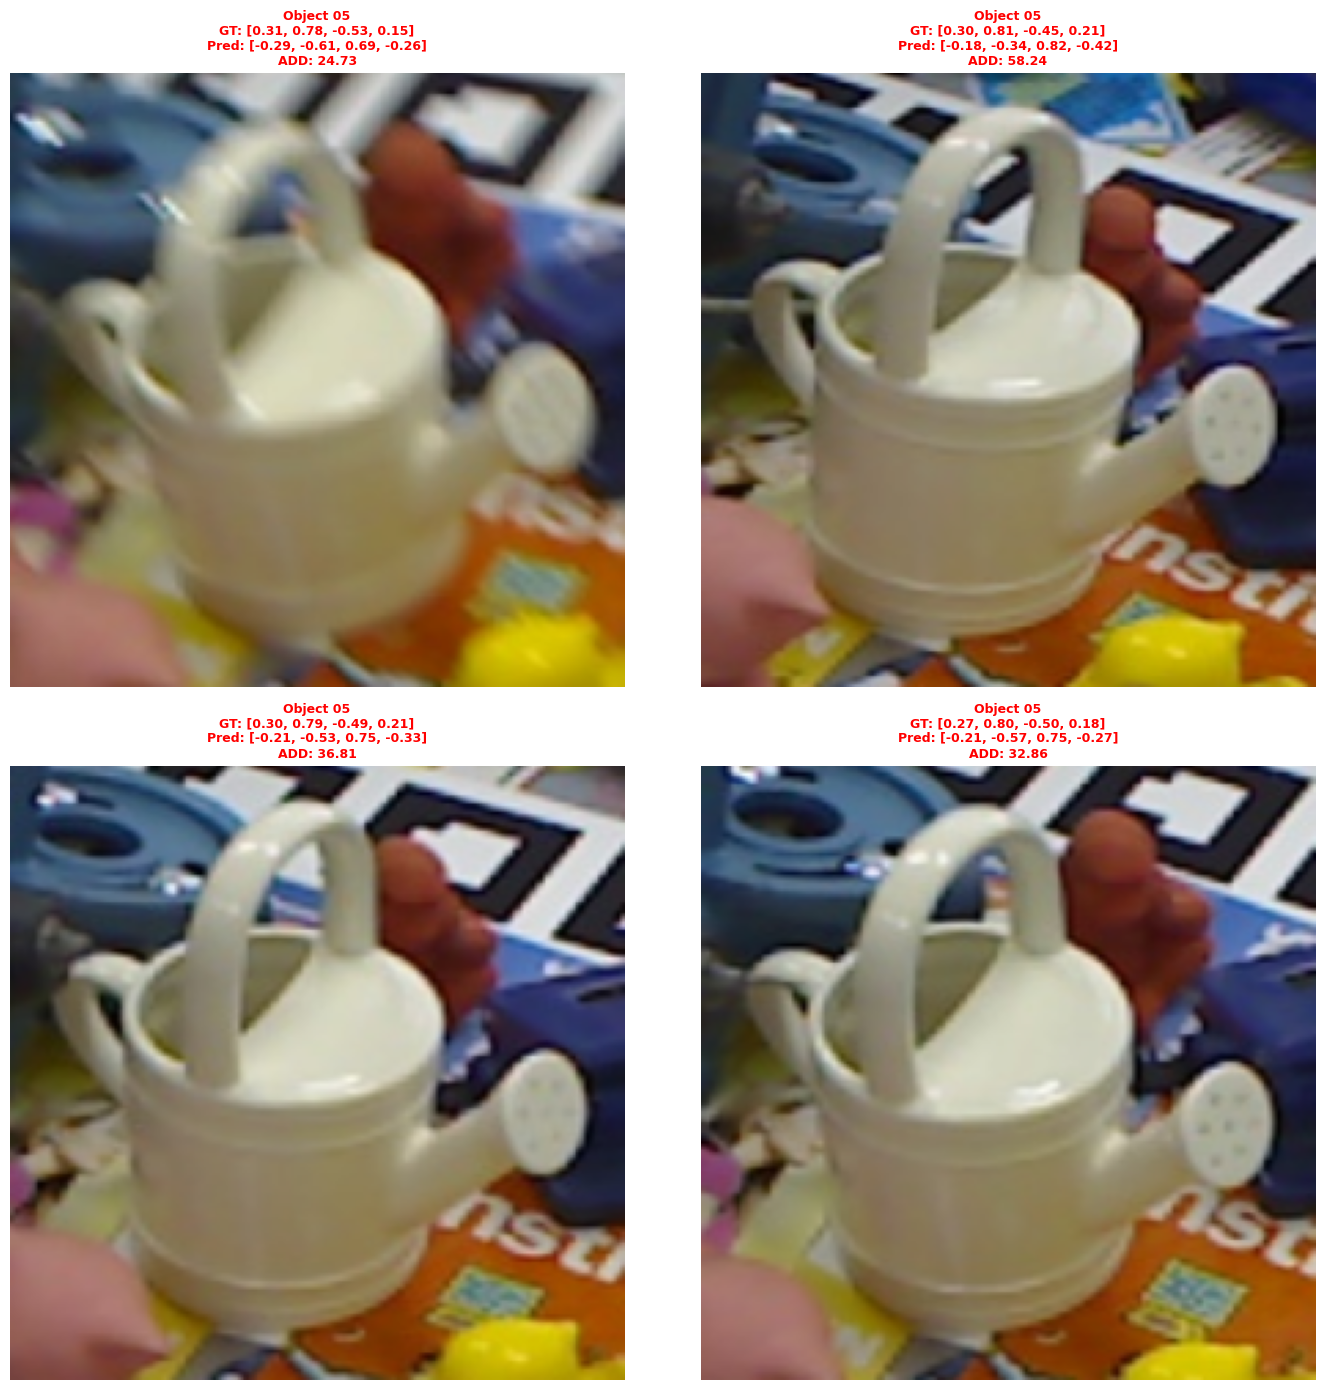

In [7]:
# Load the trained model (if needed)
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Model {NAME} loaded and in eval mode!")
except Exception as e:
    print(f"⚠️  Model not found or already loaded. Error: {e}")
    raise SystemExit("Model not found")

# Extract a random batch directly from the test dataset
print("Random batch: extracting random batch from test dataset")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Random batch start index: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # selected indices list
samples = [test_loader.dataset[i] for i in indices]
print(f"Number of samples extracted: {len(samples)}")

# Collate samples as DataLoader does
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values

print(f"Batch keys: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
gt_translations = test_batch['translation'].to(Config.DEVICE) if 'translation' in test_batch else None
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions, pred_translations = model(images)

# Convert quaternions to rotation matrices
print("\nConverting quaternions to rotation matrices")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Compute ADD full pose metric (uses utils.metrics)
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")
print("\nComputing ADD full pose metric")

results = compute_add_batch_full_pose(pred_R, pred_translations.cpu().numpy(), gt_R, gt_translations.cpu().numpy(), obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)
rot_trans_errors = results.get('add_values', None)
print(f"Test completed on {len(images)} samples")
print(f"\n📊 Mean ADD on batch:")
print(f"   Mean ADD: {np.mean(rot_trans_errors):.4f} ± {np.std(rot_trans_errors):.4f}")

# Show 4 samples with rotation+translation error
show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_trans_errors)

### 6.2 Statistics on the entire Test set

In [13]:
# Deep-only evaluation (without pinhole): saves results to CSV
run_deep_pose_pipeline(model, test_loader, name=NAME)

Model pose_rgb_endtoend loaded
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validazione GT crops (end-to-end): 100%|██████████| 210/210 [02:00<00:00,  1.75it/s]

Concatenating batches...
Computing full pose ADD metrics


Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv


### 6.3 Table: Mean ADD and Accuracy per Class


The following table shows the mean ADD error and accuracy (percentage of correct poses) for each class (object) in the LineMOD dataset.

In [14]:
# Load validation results from CSV using utils/validation.py
from utils.file_io import load_validation_results
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
val_csv_path = checkpoint_dir / 'validation_result.csv'
if val_csv_path.exists():
    results_full_pose, _ = load_validation_results(val_csv_path)
    print(f"✅ Results loaded from {val_csv_path}")
else:
    results_full_pose = globals().get('results_full_pose', None)
    if results_full_pose is None:
        print("⚠️  You must first compute the ADD full pose metric on the entire test set and save the results in 'results_full_pose'.")

✅ Results loaded from /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv


In [16]:
# Table: Rotation + translation performance (ADD full pose) using utils/validation.py
from utils.visualization import calc_add_accuracy_per_class
if results_full_pose is not None:
    data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)
    df = pd.DataFrame(data)
    display(df)
    print("\nGlobal mean ADD (full pose):", f"{global_add:.2f}")
    print("Global accuracy (full pose) (%):", f"{global_acc:.1f}")

,Class,ADD (mm),Accuracy (%)
0,01 - ape,34.44,7.4
1,02 - benchvise,67.10,11.8
2,04 - camera,69.24,9.0
3,05 - can,59.98,9.7
4,06 - cat,45.77,13.5
5,08 - driller,66.32,6.8
6,09 - duck,41.97,4.6
7,10 - eggbox,8.10,100.0
8,11 - glue,8.80,99.3
9,12 - holepuncher,50.62,5.7



Global mean ADD (full pose): 51.78
Global accuracy (full pose) (%): 22.2


### 6.4 Chart: Mean ADD per Class


The following chart shows the mean ADD error for each class, for an immediate visual comparison of the model's performance on different objects.

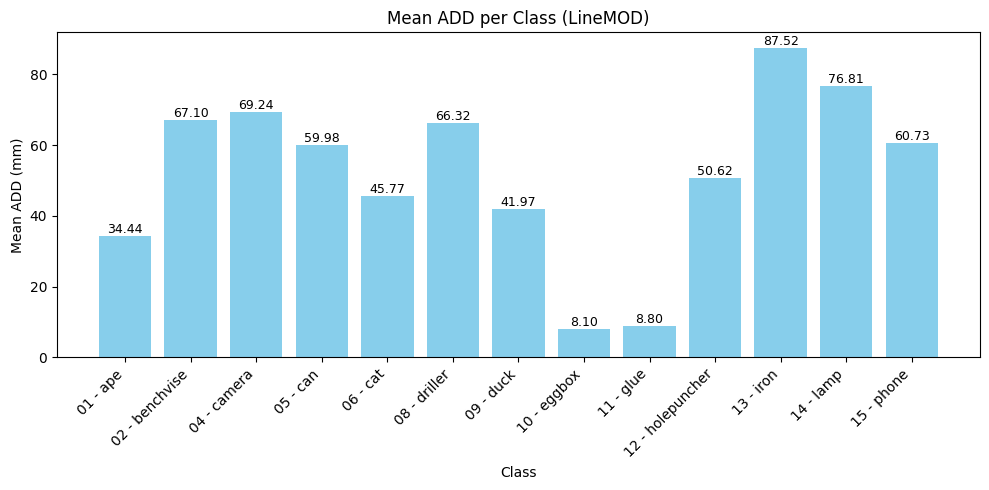

In [11]:
# Bar chart of mean ADD per class (full pose)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  You must first compute the ADD full pose metric on the entire test set and save the results in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)